# Discharge data analysis

In this notebook, we're looking at discharge data for different batteries to get a better feeling of how such a system behaves.

In [4]:
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [5]:
root_battery_data = "./analyzed_dataset"

battery_dirs = [
    "B0005",
    "B0006",
    "B0007",
    "B0018"
]

In [6]:
from typing import Dict
import os

"""The functions below allow us to work with a dict with such structure:
  {
    "battery_name1": {
      "dataset_number1" : dataset_as_DataFrame,
      "dataset_number2" : dataset_as_DataFrame,
      ...
      "dataset_number3" : dataset_as_DataFrame
    },
    ...,
    "battery_nameN": {
      "dataset_numberX" : dataset_as_DataFrame,
      "dataset_numberY" : dataset_as_DataFrame,
      ...
      "dataset_numberZ" : dataset_as_DataFrame
    }
  }
"""

def get_battery_discharge_dir(dir_root, battery_dir):
    return dir_root + "/" + battery_dir + "/discharge/"

def get_battery_datasets(battery_discharge_dir):
    datasets = {}
    for filename in os.listdir(battery_discharge_dir):
        index = os.path.splitext(filename)[0]
        filepath = battery_discharge_dir + filename
        datasets[index] = pd.read_csv(filepath)

    return datasets

def get_all_batteries_with_datasets(dir_root, batteries):
    battery_datasets = {}

    for battery in batteries:
        battery_datasets[battery] = get_battery_datasets(get_battery_discharge_dir(dir_root, battery))
    
    return battery_datasets

In [7]:
battery_datasets = get_all_batteries_with_datasets(root_battery_data, battery_dirs)

In [8]:
"""Quick visualisation of the data dictionary we're using"""
for battery in battery_datasets.keys():
    for dataset in battery_datasets[battery].keys():
        print(f"battery: {battery} dataset:{dataset} data:\n{battery_datasets[battery][dataset].head(2)}\n")

battery: B0005 dataset:05302 data:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.198342         -0.002335             23.971566        0.0006   
1          4.197871         -0.001720             23.979122        0.0008   

   Voltage_load  Time  
0         0.000  0.00  
1         4.213  9.39  

battery: B0005 dataset:05230 data:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.199185          0.000082             23.757591        0.0006   
1          4.198650          0.001152             23.755162        0.0006   

   Voltage_load  Time  
0         0.000  0.00  
1         4.215  9.36  

battery: B0005 dataset:05613 data:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.195756         -0.006175             24.030138        0.0006   
1          4.195184         -0.000889             24.032099        0.0006   

   Voltage_load   Time  
0         0.000  0.000  
1  

In [9]:
battery_dataset_sizes = {}
for battery in battery_datasets.keys():
    battery_dataset_size = 0
    for dataset in battery_datasets[battery].keys():
        battery_dataset_size += battery_datasets[battery][dataset].size
    battery_dataset_sizes[battery] = battery_dataset_size

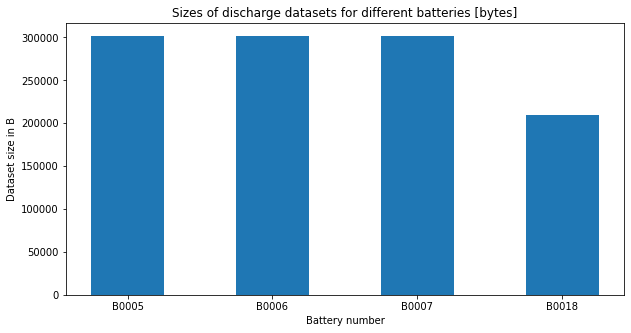

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(battery_dataset_sizes.keys(), battery_dataset_sizes.values(), 0.5)
ax.set_title("Sizes of discharge datasets for different batteries [bytes]")
ax.set_xlabel("Battery number")
ax.set_ylabel("Dataset size in B")
plt.show()

## Analysis of cell behavior across multiple cycles

In [30]:
# iterative implementation of coulomb counting
def coulomb_count(Q_0, time_series, current_series, voltage_series):
    soc = np.ones_like(current_series) # we're starting with SoC equal to 1.0, so 100%
    idx_at_cap_meas = None
    for i in range(1, len(current_series)):
        dt = time_series[i] - time_series[i - 1]
        soc[i] = soc[i - 1] + (current_series[i]/Q_0) * dt
        if (voltage_series[i] - 2.7) < 0.2: # the discharge was measured at 2.7[V]
            idx_at_cap_meas = i
    return soc, idx_at_cap_meas

def compare_discharge_capacity(Q_0, soc_final, measured_discharge_capacity):
    estimated_discharge_capacity = (1-soc_final) * (Q_0 / 3600)
    # return measured, estimated, diff, % diff
    return (measured_discharge_capacity, estimated_discharge_capacity, \
           np.abs(measured_discharge_capacity - estimated_discharge_capacity), \
           np.abs(measured_discharge_capacity - estimated_discharge_capacity) / measured_discharge_capacity * 100)

def estimate_soc_for_dataset_impl(battery, dataset, Q_0, time, current, voltage, measured_discharge_capacity):
    soc, idx_at_cap_meas = coulomb_count(Q_0, time, current, voltage)
    soc_percentage = soc * 100.0
    soc_final = soc[idx_at_cap_meas] # SoC at 2.7V is our final reading
    return soc, soc_percentage, soc_final, idx_at_cap_meas

def estimate_soc_for_dataset(datasets_dict, battery, dataset_number, initial_capacity, measured_discharge_capacity):
    if not type(dataset_number) is list:
        dataset_number = [dataset_number]
    input_dataset_count = len(dataset_number)
    if not type(initial_capacity) is list:
        initial_capacity = [initial_capacity for i in range(input_dataset_count)]
    if not type(measured_discharge_capacity) is list:
        measured_discharge_capacity = [measured_discharge_capacity for i in range(input_dataset_count)]

    list_soc_percentage = []
    list_soc_final = []
    list_meas = []
    list_estim = []
    list_diff = []
    list_per_diff = []

    fig, ax = plt.subplots(3, 2, figsize=(24, 12), constrained_layout=True)
    for i in range(input_dataset_count):

        df = datasets_dict[battery][dataset_number[i]]

        time = df["Time"].to_numpy()
        v_meas = df["Voltage_measured"].to_numpy()
        i_meas = df["Current_measured"].to_numpy()
        t_meas = df["Temperature_measured"].to_numpy()
        v_load = df["Voltage_load"].to_numpy()
        i_load = df["Current_load"].to_numpy()

        soc, soc_percentage, soc_final, idx_at_cap_meas = estimate_soc_for_dataset_impl(battery, dataset_number[i], initial_capacity[i], time, i_meas, v_meas, measured_discharge_capacity[i])

        list_soc_percentage.append(soc_percentage)
        list_soc_final.append(soc_final)

        ax[0,0].plot(time, v_meas, label=f"{dataset_number[i]}")
        ax[0,0].set_title("Measured voltage")
        ax[0,0].set_ylabel("[V]")

        ax[1,0].plot(time, i_meas)
        ax[1,0].set_title("Measured current")
        ax[1,0].set_ylabel("[A]")
        
        ax[2,0].plot(time, t_meas)
        ax[2,0].set_title("Measured temperature")
        ax[2,0].set_ylabel("[deg C]")
        ax[2,0].set_xlabel("[sec]")
        
        ax[0,1].plot(time, v_load)
        ax[0,1].set_title("Load voltage")
        ax[0,1].set_ylabel("[V]")
        
        ax[1,1].plot(time, np.abs(i_load)) # just to make the plots more similar, doesn't affect calculation
        ax[1,1].set_title("Applied load current")
        ax[1,1].set_ylabel("[A]")
        ax[1,1].set_xlabel("[sec]")
        
        ax[2,1].plot(time, soc_percentage)
        ax[2,1].vlines(time[idx_at_cap_meas], 0, 100, colors="red")
        ax[2,1].set_title("State of charge estimation based on experimental data")
        ax[2,1].set_ylabel("SoC [%]")
        ax[2,1].set_xlabel("[sec]")

        fig.align_xlabels(ax)
        fig.suptitle(f"Dataset and SoC estimation for battery: {battery} datasets: {[n for n in dataset_number]}", fontsize="large", fontweight="bold")
        fig.legend()

        meas, estim, diff, per_diff = compare_discharge_capacity(initial_capacity[i], soc_final, measured_discharge_capacity[i])
        list_meas.append(meas)
        list_estim.append(estim)
        list_diff.append(diff)
        list_per_diff.append(per_diff)

    plt.show()
    print(f"Final SoC for different datasets:")
    for i in range(len(list_soc_final)):
        print(f"{dataset_number[i]}: {list_soc_final[i]}")


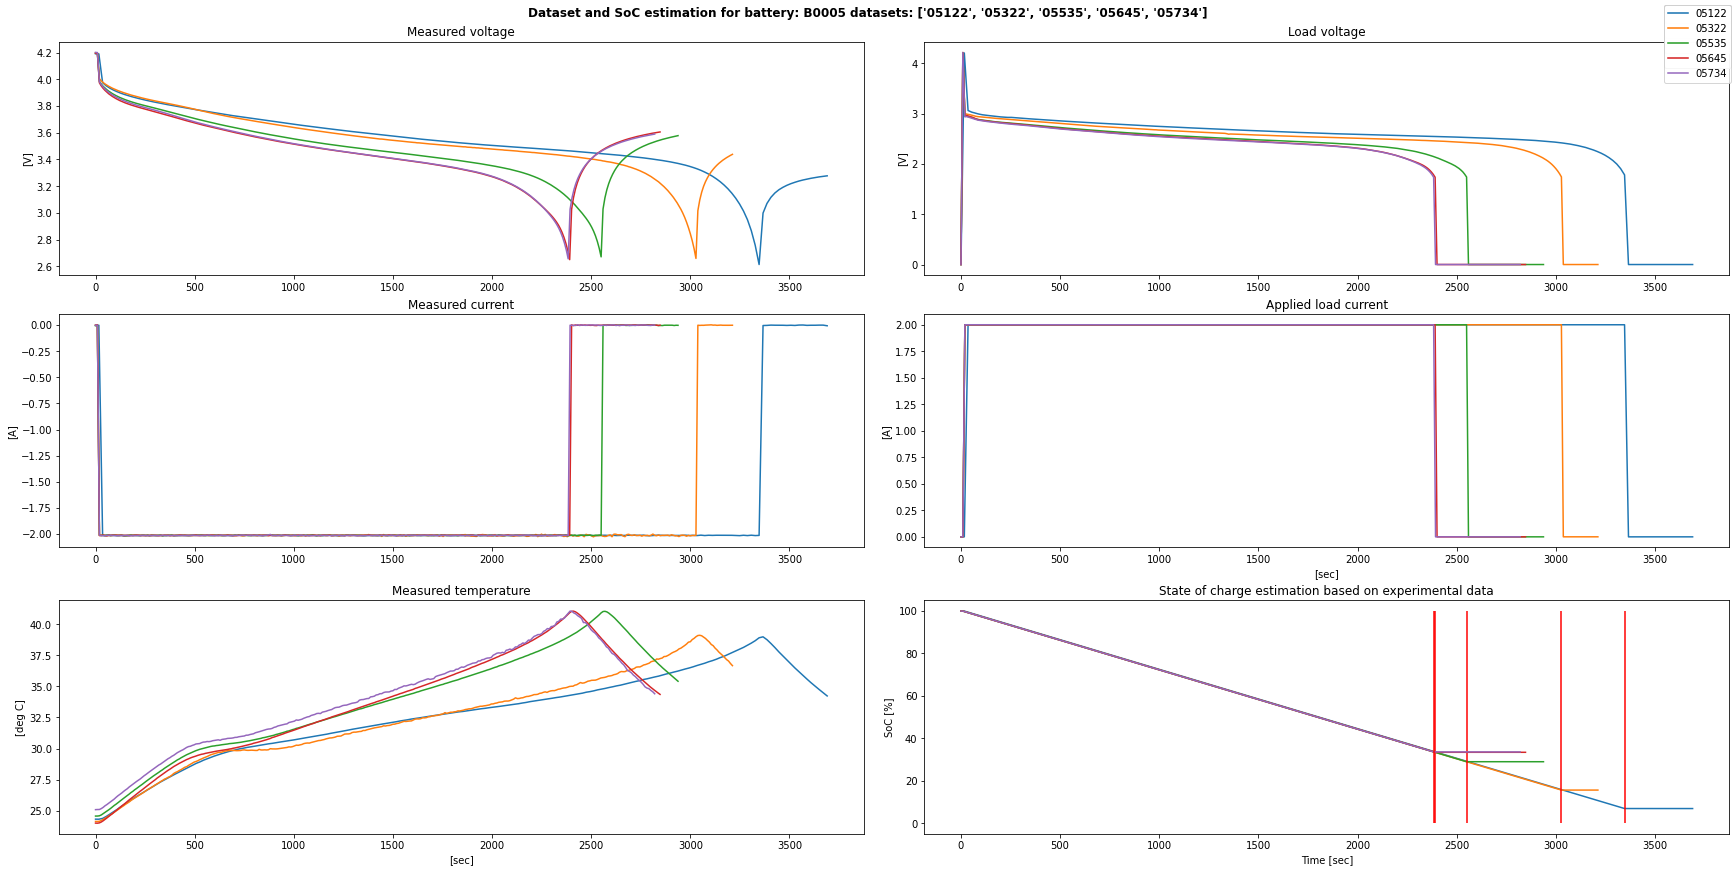

Final SoC for different datasets:
05122: 0.06911736318123866
05322: 0.15613756740269621
05535: 0.2898639885881537
05645: 0.33425856535837545
05734: 0.3360369733135228


In [31]:
Q_0 = 2 * 3600 # Asec -> because we're going to use seconds as the base, 1Ah = 1A * 3600sec = 3600Asec
datasets_for_b0005 = ["05122", "05322", "05535", "05645", "05734"]
measured_discharge_capacities = [1.8564874208181574, 1.6849029086609286, 1.417429032731308, 1.3286444309174914, 1.3250793286429356] # these values are taken from the metadata included in the original dataset
estimate_soc_for_dataset(battery_datasets, "B0005", datasets_for_b0005, Q_0, measured_discharge_capacities)